In [1]:
source("/home/user/data2/lit/bin/lit_utils.R")
source("/home/user/data3/lit/project/sORFs/sORFs.utils.R")
lib_text()
lib_plot()

##### 起始密码子附近的kozak序列 ##### 
get_window_15_start_codon <- function(df){
  df %>% filter(Strand=="+") ->  all_sep_forward
  data.frame(all_sep_forward$Chr,all_sep_forward$Start-15,all_sep_forward$Start+18,all_sep_forward$ORF_id_trans,".",
             all_sep_forward$Strand) -> window_15_start_codon_f
  df %>% filter(Strand=="-") ->  all_sep_reverse
  data.frame(all_sep_reverse$Chr,all_sep_reverse$End-18,all_sep_reverse$End+15,all_sep_reverse$ORF_id_trans,".",
             all_sep_reverse$Strand) -> window_15_start_codon_r
  colnames(window_15_start_codon_r) <- colnames(window_15_start_codon_f)
  rbind(window_15_start_codon_f,window_15_start_codon_r) -> window_15_start_codon
  return(window_15_start_codon)
}
## 方法一
# 输入fasta所在的路径
seqlogo_cus <- function(fasta_path,output_path,keep_start_codon_or_not){
  library(seqLogo)
  library(Biostrings)
  # 读取 FASTA 文件
  seqs <- readDNAStringSet(fasta_path)
  # 直接计算碱基频率矩阵（PFM）
  pfm <- consensusMatrix(seqs)[1:4, ]  # 只保留A/C/G/T
  rownames(pfm) <- c("A", "C", "G", "T")
  # 检查PFM（确保无NA/Inf值）
  print(pfm[, 1:5])  # 查看前5列
  if(!keep_start_codon_or_not){
    pfm[,c(1:15,19:33)] -> pfm
  }
  # 转换为PWM（需确保所有列和为1）
  pwm <- makePWM((pfm) / colSums(pfm))  # 加伪计数避免除零错误
  # 绘制Sequence Logo
  pdf(output_path, width = 7, height = 4)  # 可自定义尺寸
  seqLogo(pwm)
  dev.off()
}
## 方法二
# 读取 FASTA 文件
ggseqlogo_cus <- function(fasta_path,output_path,keep_start_codon_or_not){
  library(ggseqlogo)
  library(Biostrings)
  seqs <- readDNAStringSet(fasta_path)
  ggseqlogo(as.character(seqs)) -> p
  if(!keep_start_codon_or_not){
    sub <- sapply(as.character(seqs), function(s) paste0(substr(s, 1, 15), substr(s, 19, 33)))
    ggseqlogo(sub) -> p
  }
  ggsave(p,filename = output_path, width = 7, height = 4)
}
inte_func <- function(sep,output_path,name,only_cano){
  # 参数一：整理好的蛋白质元信息数据框，需要包括起始密码子的位置以及起始密码子的类型（如果需要用到only_cano）
  # 参数二：输出路径
  # 参数三：文件名前缀
  # 参数四：是否只统计起始密码子，需要包括这一列（输入的值为0，1，2）
  if(only_cano==1){
    get_window_15_start_codon(sep %>% filter(Scodon=="ATG")) -> window_15_start_codon_sep
  }else if(only_cano==0){
    get_window_15_start_codon(sep %>% filter(Scodon!="ATG")) -> window_15_start_codon_sep
  }else{
    get_window_15_start_codon(sep) -> window_15_start_codon_sep
  }
  create_path(output_path)
  output_bed <- paste0(output_path,name,".bed")
  output_fa <- paste0(output_path,name,".fa")
  output_pdf <- paste0(output_path,name,".pdf")
  fwrite(window_15_start_codon_sep,output_bed,col.names = F,sep = '\t')
  command <- paste0("bedtools getfasta -s -fi /home/user/data/lit/database/public/genome/hg38/hg38.fa -bed ",
                    output_bed," > ",output_fa)
  system(command)
  ggseqlogo_cus(output_fa,output_pdf,TRUE)
  ggseqlogo_cus(output_fa,paste0(output_path,name,".nosc.pdf"),FALSE)
  seqlogo_cus(output_fa, paste0(output_path,name,".seqlogo.pdf"),TRUE)
}


In [2]:
# 非经典的极少部分小肽也被注释为经典小肽
sep_combined_path <- "../processed/sep_combined/sep_combined_unique.txt"
fread_c(sep_combined_path) -> sep_combined
# table(sep_combined$Type)

In [3]:
sep_combined %>% filter(Type=="Canonical") -> cano_sep
sep_combined %>% filter(Type!="Canonical") %>% filter(Unique_psm_n>0) -> noncano_sep_ms_suppo
sep_combined %>% filter(Type!="Canonical") %>% filter(Unique_psm_n==0) -> noncano_sep_ms_not_suppo
nrow(cano_sep)
nrow(noncano_sep_ms_suppo)
nrow(noncano_sep_ms_not_suppo)

[1] 3243

[1] 2141

[1] 2141


    Canonical Non-canonical 
         3243          2141 

Warning message in brewer.pal(n = 2, name = "Set3"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


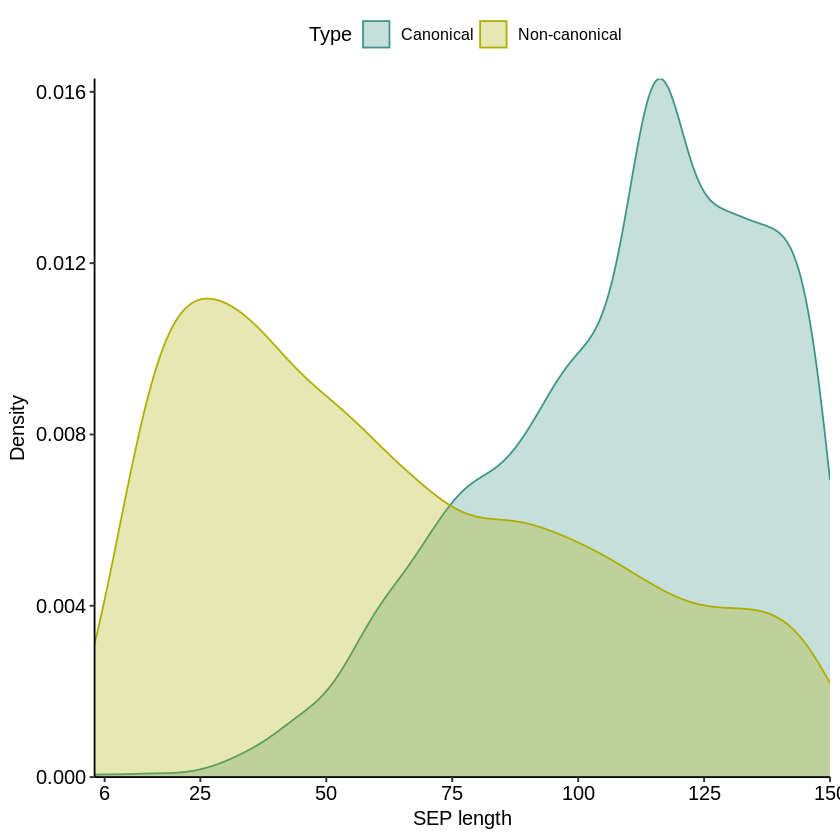

In [4]:
# 这里的长度比较应该也是比较所有的经典小蛋白和在这个研究中鉴定出来的小蛋白
output_path <- "/home/user/data3/lit/project/sORFs/02-Mass-spec-20250723/analysis/20250723_analysis/figures"
rbind(cano_sep,noncano_sep_ms_suppo) -> df
df %>% mutate(Cano_type=
                case_when(Type == "Canonical" ~ "Canonical",
                          TRUE ~ "Non-canonical")) -> df
table(df$Cano_type)
colors <- colorspace::darken(brewer.pal(n=2,name="Set3"),0.3)
## 3) 密度图：展示不同 Cano_type 的 Length 分布
p_dens <- ggplot(df, aes(x = Length, colour = Cano_type, fill = Cano_type)) +
  geom_density(alpha = 0.3, adjust = 1) +
  labs(x = "SEP length", y = "Density", colour = "Type", fill = "Type") +
  theme_3()+
scale_fill_manual(values = colors)+
scale_color_manual(values = colors)+
  scale_x_continuous(breaks = c(6,seq(0, max(df$Length), by = 25)),expand = c(0,0)) +
  scale_y_continuous(,expand = c(0,0)) 
p_dens
ggsave(p_dens,filename = o("cano_non_cano_length_density.pdf"),height = 5,width = 5)

In [5]:
colnames(df)
table(df$ORF_type_2)

[1] "Uniprot_id"       "ENS_id"           "Seq"              "Length"          
 [5] "Chr"              "Strand"           "Start"            "End"             
 [9] "ORF_id_trans"     "ORF_id_seq"       "Scodon"           "Type"            
[13] "ORF_type_1"       "ORF_type_2"       "ORF_type_3"       "Gene_ID"         
[17] "Transcript_type"  "Gene_type"        "Gene_name"        "CDS_start"       
[21] "CDS_end"          "PE_type"          "All_psm_n"        "All_peptide_n"   
[25] "Unique_psm_n"     "Unique_peptide_n" "Cano_type"


       Canonical            doORF             dORF        Extension 
            3246               13              110                1 
        Internal     ncORF_lncRNA      ncORF_other ncORF_pseudogene 
              47              504                2              310 
      Truncation            uoORF             uORF 
            1114                7               30 

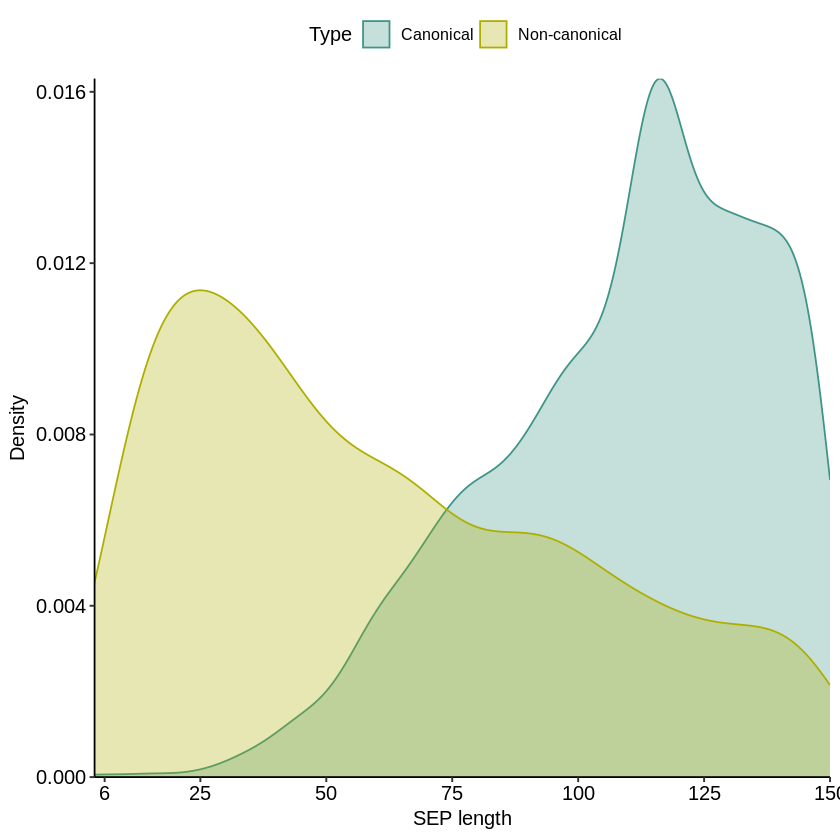

In [6]:
# head(df)
df %>% filter(ORF_type_2!="Truncation") -> df_1
p_dens <- ggplot(df_1, aes(x = Length, colour = Cano_type, fill = Cano_type)) +
  geom_density(alpha = 0.3, adjust = 1) +
  labs(x = "SEP length", y = "Density", colour = "Type", fill = "Type") +
  theme_3()+
scale_fill_manual(values = colors)+
scale_color_manual(values = colors)+
  scale_x_continuous(breaks = c(6,seq(0, max(df$Length), by = 25)),expand = c(0,0)) +
  scale_y_continuous(,expand = c(0,0)) 
p_dens

In [4]:
for (i in 2){
if(i==0){
    prefix="noncano"
}else if(i==1){
    prefix="cano"
}else{
    prefix="all"
}
inte_func(cano_sep,
        paste0("../figures/cano_sep_scodon_kozak/",prefix,"/"),
        "prefix",
        i
)
}
for (i in 2){
if(i==0){
    prefix="noncano"
}else if(i==1){
    prefix="cano"
}else{
    prefix="all"
}
inte_func(noncano_sep_ms_not_suppo,
        paste0("../figures/noncano_sep_ms_not_suppo_scodon_kozak/",prefix,"/"),
        "prefix",
        i
)
}

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:tidyr’:

    expand


The following objects are masked from ‘

  [,1] [,2] [,3] [,4] [,5]
A  560  630  616  682  662
C 1008 1015 1028  992 1125
G  909  871  882  912  807
T  766  727  717  657  649
  [,1] [,2] [,3] [,4] [,5]
A  588  580  570  603  585
C  497  488  462  449  478
G  483  513  551  521  487
T  573  560  558  568  591


In [5]:
for (i in 0:2){
if(i==0){
    prefix="noncano"
}else if(i==1){
    prefix="cano"
}else{
    prefix="all"
}
inte_func(noncano_sep_ms_suppo,
        paste0("../figures/noncano_sep_ms_suppo_scodon_kozak/",prefix,"/"),
        "prefix",
        i
)
}
noncano_sep_ms_suppo %>% filter(ORF_type_3=="Truncation") -> df
for (i in 0:2){
if(i==0){
    prefix="noncano"
}else if(i==1){
    prefix="cano"
}else{
    prefix="all"
}
inte_func(df,
        paste0("../figures/noncano_sep_ms_suppo_truncation_scodon_kozak/",prefix,"/"),
        "prefix",
        i
)
}

  [,1] [,2] [,3] [,4] [,5]
A  350  447  274  369  415
C  355  342  424  359  351
G  446  296  431  422  277
T  286  352  308  287  394
  [,1] [,2] [,3] [,4] [,5]
A  178  224  134  192  212
C  180  185  197  196  167
G  225  117  199  196  137
T  121  178  174  120  188
  [,1] [,2] [,3] [,4] [,5]
A  528  671  408  561  627
C  535  527  621  555  518
G  671  413  630  618  414
T  407  530  482  407  582
  [,1] [,2] [,3] [,4] [,5]
A  164  247  106  189  229
C  183  191  233  179  173
G  261  123  239  237  116
T  125  172  155  128  215
  [,1] [,2] [,3] [,4] [,5]
A  100  120   64  106  110
C   88   90  109   98   96
G  133   66  117  119   74
T   60  105   91   58  101
  [,1] [,2] [,3] [,4] [,5]
A  264  367  170  295  339
C  271  281  342  277  269
G  394  189  356  356  190
T  185  277  246  186  316


In [7]:
noncano_sep_ms_suppo %>% filter(ORF_type_3!="Truncation") -> df
for (i in 0:2){
if(i==0){
    prefix="noncano"
}else if(i==1){
    prefix="cano"
}else{
    prefix="all"
}
inte_func(df,
        paste0("../figures/noncano_sep_ms_suppo_not_truncation_scodon_kozak/",prefix,"/"),
        "prefix",
        i
)
}

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:tidyr’:

    expand


The following objects are masked from ‘

  [,1] [,2] [,3] [,4] [,5]
A  186  200  168  180  186
C  172  151  191  180  178
G  185  173  192  185  161
T  161  180  153  159  179
  [,1] [,2] [,3] [,4] [,5]
A   78  104   70   86  102
C   92   95   88   98   71
G   92   51   82   77   63
T   61   73   83   62   87
  [,1] [,2] [,3] [,4] [,5]
A  264  304  238  266  288
C  264  246  279  278  249
G  277  224  274  262  224
T  222  253  236  221  266


In [13]:
head(df)
table(df$Scodon)
nrow(df)

,Uniprot_id,ENS_id,Seq,Length,Chr,Strand,Start,End,ORF_id_trans,ORF_id_seq,⋯,Transcript_type,Gene_type,Gene_name,CDS_start,CDS_end,PE_type,All_psm_n,All_peptide_n,Unique_psm_n,Unique_peptide_n
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>
1,ENST00000000233.10+chr7:127590977-127591299,ENST00000000233.10,LRDAVLLVFANKQDMPNAMPVSELTDKLGLQHLRSRTWYVQATCATQGTGLYDGLDWLSHELSKR,65,chr7,+,127590977,127591299,ENST00000000233.10+chr7:127590977-127591299,+chr7:127590977-127591299:LRDAVLLVFANKQDMPNAMPVSELTDKLGLQHLRSRTWYVQATCATQGTGLYDGLDWLSHELSKR,⋯,protein_coding,protein_coding,ARF5,127588498,127591299,,1,1,1,1
2,ENST00000000233.10+chr7:127590989-127591299,ENST00000000233.10,VLLVFANKQDMPNAMPVSELTDKLGLQHLRSRTWYVQATCATQGTGLYDGLDWLSHELSKR,61,chr7,+,127590989,127591299,ENST00000000233.10+chr7:127590989-127591299,+chr7:127590989-127591299:VLLVFANKQDMPNAMPVSELTDKLGLQHLRSRTWYVQATCATQGTGLYDGLDWLSHELSKR,⋯,protein_coding,protein_coding,ARF5,127588498,127591299,,2,1,2,1
3,ENST00000000233.10+chr7:127591031-127591299,ENST00000000233.10,MPVSELTDKLGLQHLRSRTWYVQATCATQGTGLYDGLDWLSHELSKR,47,chr7,+,127591031,127591299,ENST00000000233.10+chr7:127591031-127591299,+chr7:127591031-127591299:MPVSELTDKLGLQHLRSRTWYVQATCATQGTGLYDGLDWLSHELSKR,⋯,protein_coding,protein_coding,ARF5,127588498,127591299,,6,1,6,1
4,ENST00000007516.8-chr16:23582283-23582340,ENST00000007516.8,MCPQEIVDYIADKKDVYE,18,chr16,-,23582283,23582340,ENST00000007516.8-chr16:23582283-23582340,-chr16:23582283-23582340:MCPQEIVDYIADKKDVYE,⋯,protein_coding,protein_coding,NDUFAB1,23582283,23596290,,6,2,6,2
5,ENST00000007516.8-chr16:23582283-23585351,ENST00000007516.8,MEDEFGFEIPDIDAEKLMCPQEIVDYIADKKDVYE,35,chr16,-,23582283,23585351,ENST00000007516.8-chr16:23582283-23585351,-chr16:23582283-23585351:MEDEFGFEIPDIDAEKLMCPQEIVDYIADKKDVYE,⋯,protein_coding,protein_coding,NDUFAB1,23582283,23596290,,1,1,1,1
6,ENST00000007516.8-chr16:23582283-23585357,ENST00000007516.8,MAMEDEFGFEIPDIDAEKLMCPQEIVDYIADKKDVYE,37,chr16,-,23582283,23585357,ENST00000007516.8-chr16:23582283-23585357,-chr16:23582283-23585357:MAMEDEFGFEIPDIDAEKLMCPQEIVDYIADKKDVYE,⋯,protein_coding,protein_coding,NDUFAB1,23582283,23596290,,5,1,5,1



AAG ACG AGG ATA ATC ATG ATT CTG GTG TTG 
101  50  31  33  99 381  89 151 149  30 

[1] 1114